In [33]:
#Deandra Spike-Madden
#500946801

# ------------------------- IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem import PorterStemmer
from nltk.stem import 	WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from tqdm import tqdm

nltk.download('wordnet')
nltk.download('omw-1.4')
stopwords = np.loadtxt("cacm_stopwords.txt",dtype=str)
vectorizer = TfidfVectorizer(analyzer='word', norm ='l2',stop_words={'english'})
kos_vocab = np.loadtxt("vocab.kos.txt", dtype=str)

pca = PCA(3)

# --------------------------------------------- PREPROCESSING 

def build_vocab(kos_vocab): # Assigning word id to vocab
    vocab = {}
    for i in range(len(kos_vocab)):
        vocab[str(i+1)]=kos_vocab[i]
    return vocab

def build_document(vocabulary): # Build each document as a string
    doc_ids_plain = {}
    documents_plain = []

    # Get word ids per document
    with open("docword.kos.txt") as file:
        for line in file:
            content = line.split(" ")
            if len(content)>1:
                if content[0] in doc_ids_plain: doc_ids_plain[content[0]].append(content[1])
                else: doc_ids_plain[content[0]]=[content[1]]     
            else: continue

    # Turn word ids into words to build each document
    for i in doc_ids_plain:
        row = []
        for j in doc_ids_plain[i]:
            if "_" in vocabulary[j]: 
                temp = vocabulary[j].replace("_"," ")
                row.append(temp)
            else: row.append(vocabulary[j])
        documents_plain.append(" ".join(row))

    return documents_plain

def vectorize_document(documents_dict,vectorizer): # vectorize .....
    X = vectorizer.fit_transform(documents_dict)
    return X

def more_digits(word): #Checks if word contains more letters than numbers
    l = len(word)
    numbers = len("".join(re.findall('[0-9]+', word)))
    letters = len("".join(re.findall('[^0-9]', word)))
    if (numbers/l)<=(letters/l):
        return False
    return True

def update_kos_vocab(kos_vocab): #Removing underscores from vocab then assigning word id to vocab

    build_vocab = []

    for i in range(len(kos_vocab)): # Cleaning vocab
        clean=kos_vocab[i].replace("_"," ").strip()
        build_vocab.append(clean)

    with open('updated_vocab.kos.txt', 'a') as f: # Writing clean vocab to txt
        f.write('\n'.join(build_vocab))
    
    updated_kos_vocab = {}

    with open("updated_vocab.kos.txt",'r') as file_obj:
        words = file_obj.readlines()
        for i in range(len(words)):
            updated_kos_vocab[str(i+1)]=words[i].strip() # Strip to remove new line
    return updated_kos_vocab

#------------Stemming

def build_document_ps(updated_vocab):
    porter_stemmer = PorterStemmer() # to reduce redundancy in documents
 
    doc_word_ids = {}
    # Get word ids per document
    with open("docword.kos.txt") as file:
        for line in file:
            content = line.split(" ")
            if len(content)>1:
                if content[0] in doc_word_ids: doc_word_ids[content[0]].append(content[1])
                else: doc_word_ids[content[0]]=[content[1]]     
            else: continue

    #Construct documents
    kos_documents_ps = []
    for document in doc_word_ids:
        row = []
        for word_id in doc_word_ids[document]:
            word = updated_vocab[word_id]
            if word in stopwords:continue
            if more_digits(word): continue # more letters in word than numbers
            stemmed = porter_stemmer.stem(word) # Stem words using porter algorithm
            if stemmed in row: continue # Remove redundancy in documents
            row.append(stemmed)
        kos_documents_ps.append(" ".join(row))
    return kos_documents_ps

# --------------------------------------------- OPTIMAL K VALUE
def find_optimal_kV1(min,max,vec_documents):
    model = KMeans(init = 'k-means++', max_iter = 300, n_init = 10)
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(min,max), timings=False)
    visualizer.fit(vec_documents)        # Fit the data to the visualizer
    visualizer.show() 

#--------------------------------------------- TESTING KMEANS CLUSTERS

def kmeans(document_vec,k,pca,type):
    terms_in_cluster = {}

    # Creating Model
    model = KMeans(n_clusters= k, init='k-means++', random_state=42)
    
    #Transform the data
    df = pca.fit_transform(document_vec.todense())

    y_model =  model.fit(document_vec) #to be able to retrieve each term
    labels_model = y_model.labels_
    
    print("Inertia for model with " +str(k)+ " clusters is: " + str(y_model.inertia_))

    print("Top 40 terms in each cluster (K="+str(k)+","+type+")")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out ()

    for i in range(k):
        cloud_data = ""
        clus = []

        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :40]:
            print(' %s' % terms[ind], end='')
            cloud_data+=terms[ind] + " "
            clus.append(terms[ind])
        terms_in_cluster[i]=clus
        print()
        print()
        word_cloud = WordCloud(collocations = False, background_color = 'white',colormap='tab20',).generate(cloud_data)
        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    
    y_model =  model.fit(df) # graphing clusters 
    labels_model = y_model.labels_
    #Plot clusters in 2d
    plt.figure(figsize=(20,10))

    #Getting the Centroids
    centroids = model.cluster_centers_
    u_labels = np.unique(labels_model)
    
    #plotting the results:
    for i in u_labels:
        plt.scatter(df[labels_model == i , 0] , df[labels_model == i , 1] , label = i,s=15)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.title("Kmeans Clusters - 2D (K="+str(k)+","+type+")",fontsize=14)
    plt.legend(fontsize=20)
    plt.show()

    #Plot clusters 3d
    fig= plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    
    #plotting the results:
    for i in u_labels:
        ax.scatter(df[labels_model == i , 0] , df[labels_model == i , 1],  df[labels_model == i , 2],label = i,s=8)
    ax.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.title("Kmeans Clusters - 2D (K="+str(k)+","+"Stemmed"+")",fontsize=14)
    plt.legend(fontsize=13)
    plt.show()
    return [model,terms_in_cluster]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\deand\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Inertia for model with 4 clusters is: 3132.3447332229607
Top 40 terms in each cluster (K=4,Stemmed)
Cluster 0: dryfli endspan var fe openhttpwwwedwardsforprezcomdailykoshtml altsit sunzoo republicansforkerri newwindow montclair startspan boxblogrol boxfeed boxrdf calistan racin bushsux usernam watcher asap admin faq login meter ourcongressorg password philli menu dkosopedia store function calcul midday homepag section list kossack locat scoop straight



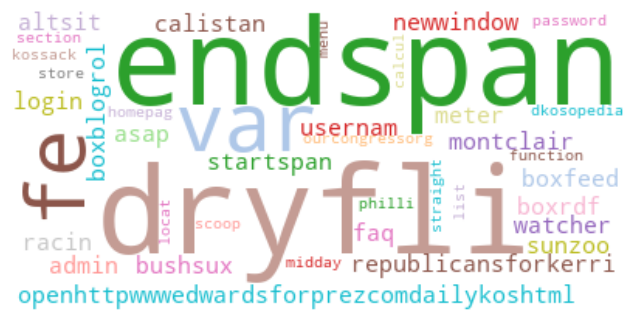

Cluster 1: iraq administr war bush presid american militari peopl time nation attack iraqi report govern year gener countri unit offici news state secur forc kill white troop question terror polici call polit press issu georg hous john public apr terrorist offic



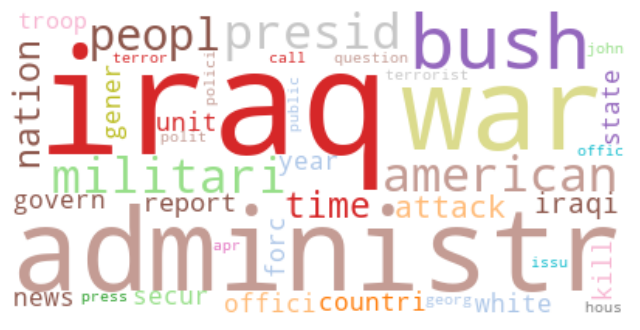

Cluster 2: edward clark dean lieberman gephardt primari sharpton kucinich braun kerri democrat poll result jan undecid parenthesi iowa latest number feb arg dec state trend zogbi lead candid percent win race susa track support contest hampshir momentum place report gep nation



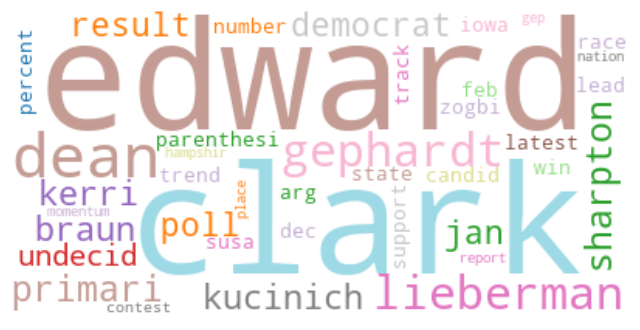

Cluster 3: elect gener democrat republican poll bush kerri campaign race candid time state parti senat oct hous vote gop john win presid number voter polit year nation news peopl presidenti report lead support percent media result money primari show ill rais



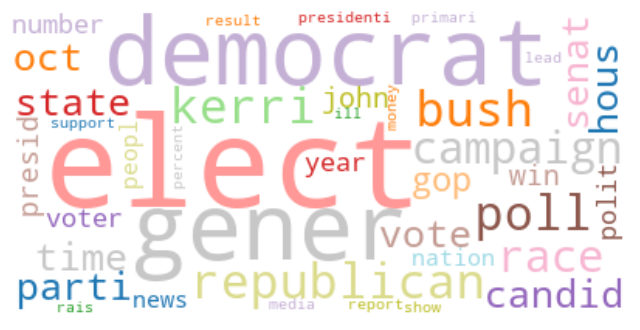

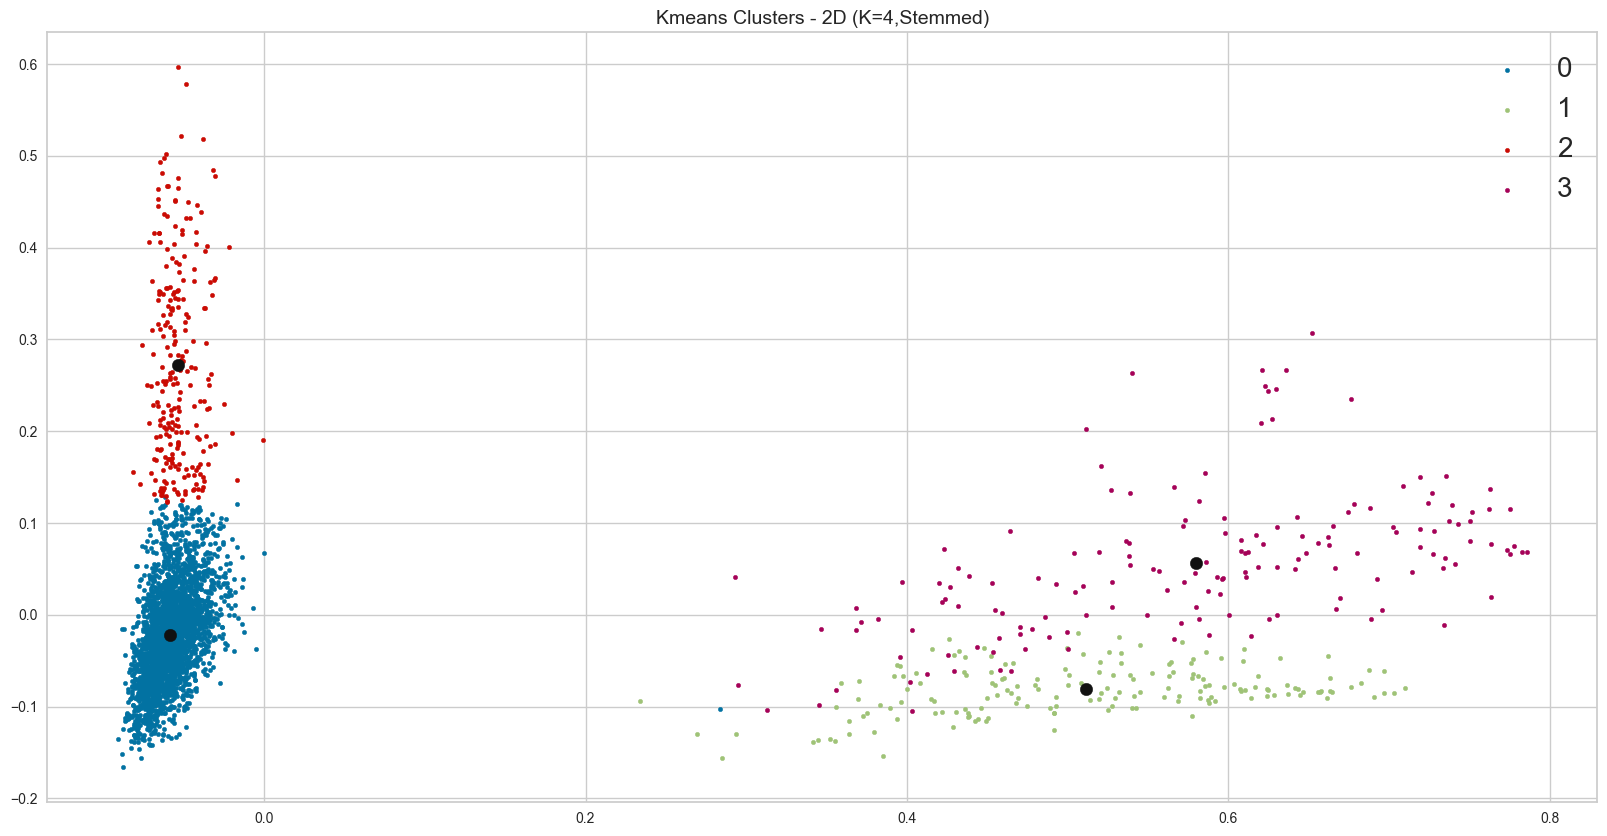

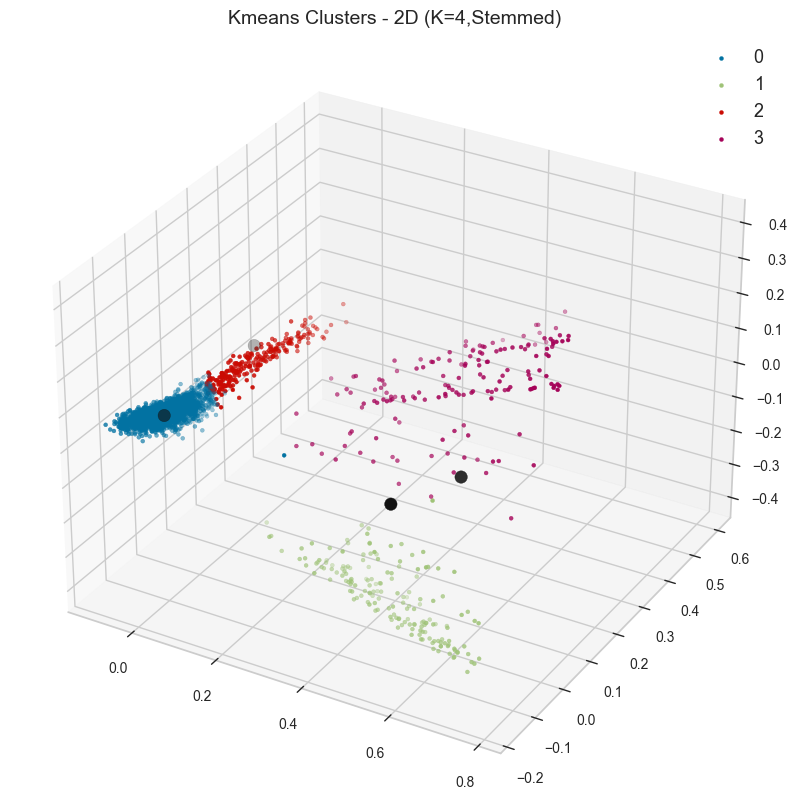

[KMeans(n_clusters=4, random_state=42),
 {0: ['dryfli',
   'endspan',
   'var',
   'fe',
   'openhttpwwwedwardsforprezcomdailykoshtml',
   'altsit',
   'sunzoo',
   'republicansforkerri',
   'newwindow',
   'montclair',
   'startspan',
   'boxblogrol',
   'boxfeed',
   'boxrdf',
   'calistan',
   'racin',
   'bushsux',
   'usernam',
   'watcher',
   'asap',
   'admin',
   'faq',
   'login',
   'meter',
   'ourcongressorg',
   'password',
   'philli',
   'menu',
   'dkosopedia',
   'store',
   'function',
   'calcul',
   'midday',
   'homepag',
   'section',
   'list',
   'kossack',
   'locat',
   'scoop',
   'straight'],
  1: ['iraq',
   'administr',
   'war',
   'bush',
   'presid',
   'american',
   'militari',
   'peopl',
   'time',
   'nation',
   'attack',
   'iraqi',
   'report',
   'govern',
   'year',
   'gener',
   'countri',
   'unit',
   'offici',
   'news',
   'state',
   'secur',
   'forc',
   'kill',
   'white',
   'troop',
   'question',
   'terror',
   'polici',
   'cal

In [32]:
updated_kos_vocab = update_kos_vocab(kos_vocab)
documents_ps = build_document_ps(updated_kos_vocab)
vec_kos_documents_ps= vectorize_document(documents_ps,vectorizer)
kmeans(vec_kos_documents_ps,4,pca,"Stemmed")


C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.

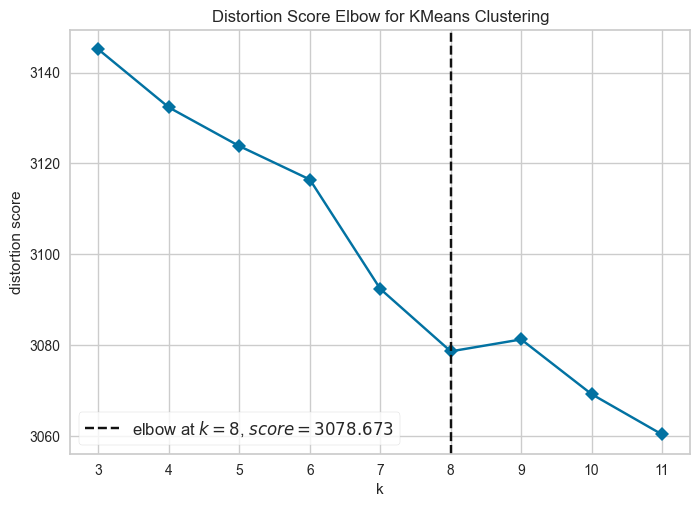

In [44]:
find_optimal_kV1(3,12,vec_kos_documents_ps) # finding optimal k using package (Elbow Method)

C:\Users\deand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Inertia for model with 4 clusters is: 3132.3447332229607
Top 50 terms in each cluster (K=4,Stemmed)
Cluster 0: dryfli endspan var fe openhttpwwwedwardsforprezcomdailykoshtml altsit sunzoo republicansforkerri newwindow montclair startspan boxblogrol boxfeed boxrdf calistan racin bushsux usernam watcher asap admin faq login meter ourcongressorg password philli menu dkosopedia store function calcul midday homepag section list kossack locat scoop straight steal recommend contact split cultur select ticket experi labor need



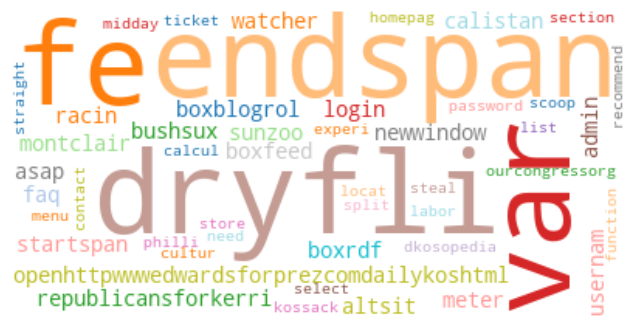

Cluster 1: iraq administr war bush presid american militari peopl time nation attack iraqi report govern year gener countri unit offici news state secur forc kill white troop question terror polici call polit press issu georg hous john public apr terrorist offic includ kerri fact continu support plan sun turn soldier make



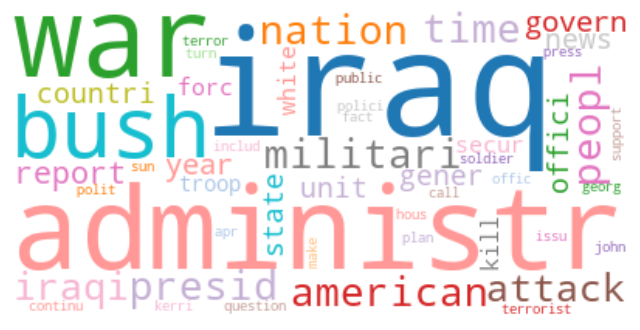

Cluster 2: edward clark dean lieberman gephardt primari sharpton kucinich braun kerri democrat poll result jan undecid parenthesi iowa latest number feb arg dec state trend zogbi lead candid percent win race susa track support contest hampshir momentum place report gep nation show john line trapper vote pdf ill nov voter time



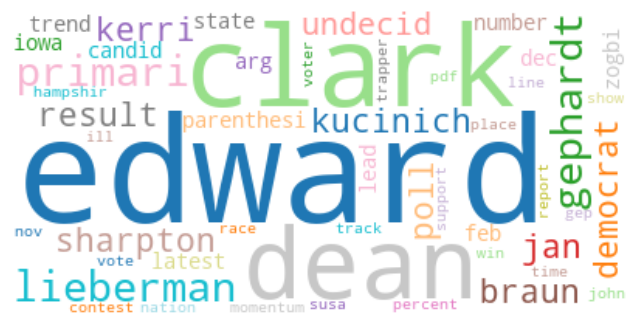

Cluster 3: elect gener democrat republican poll bush kerri campaign race candid time state parti senat oct hous vote gop john win presid number voter polit year nation news peopl presidenti report lead support percent media result money primari show ill rais close run expect call ive effort interest seat sep jul



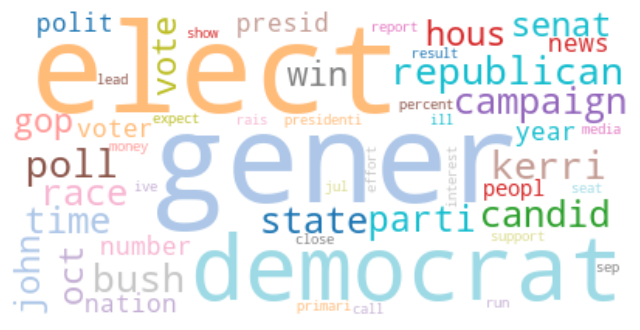

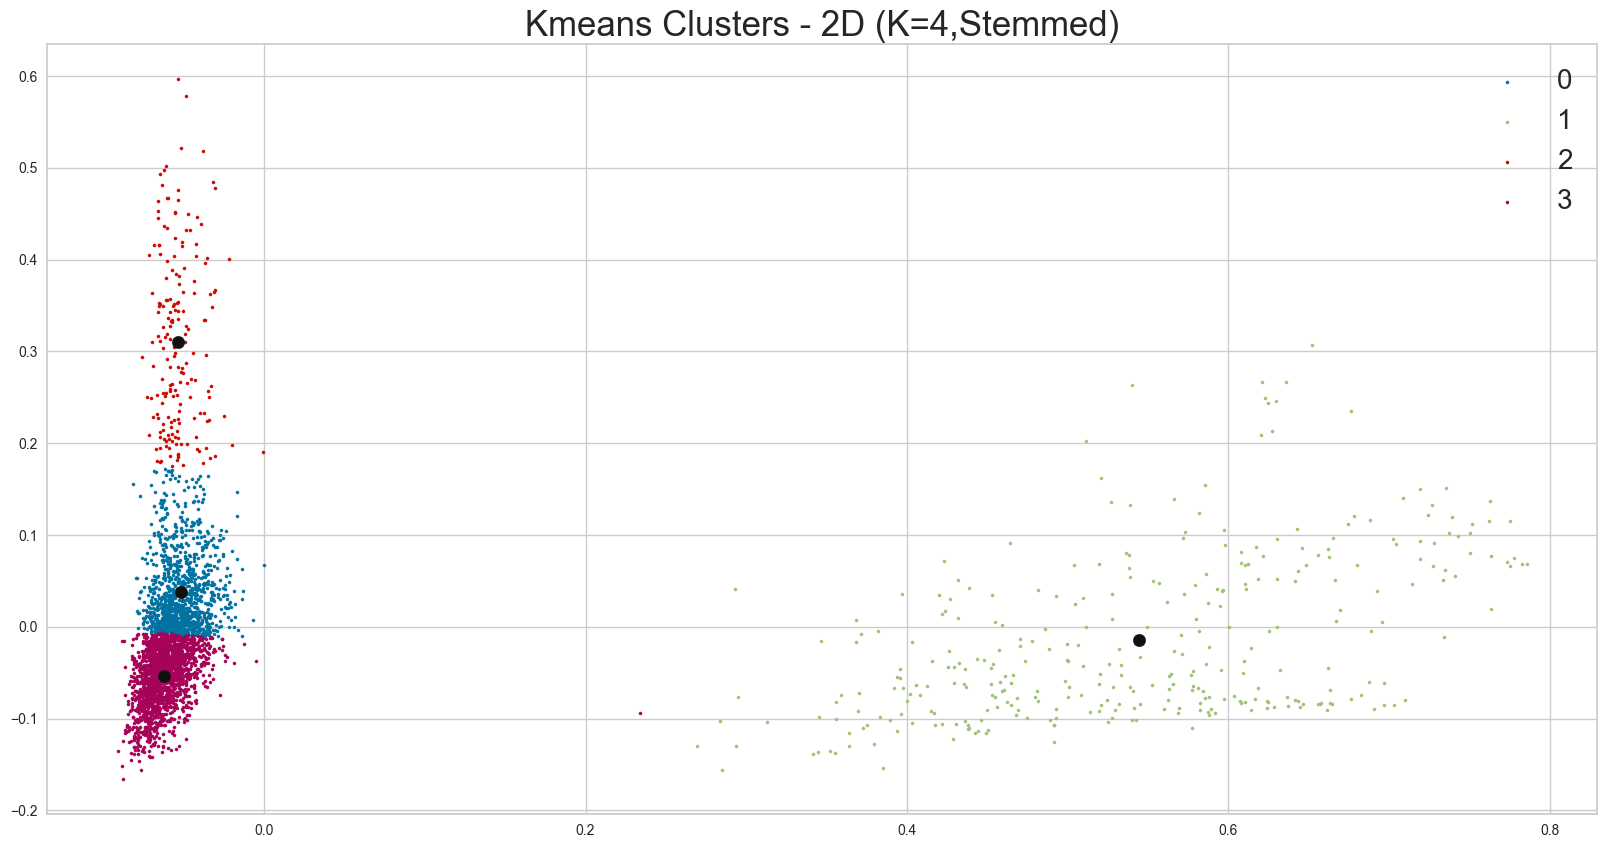

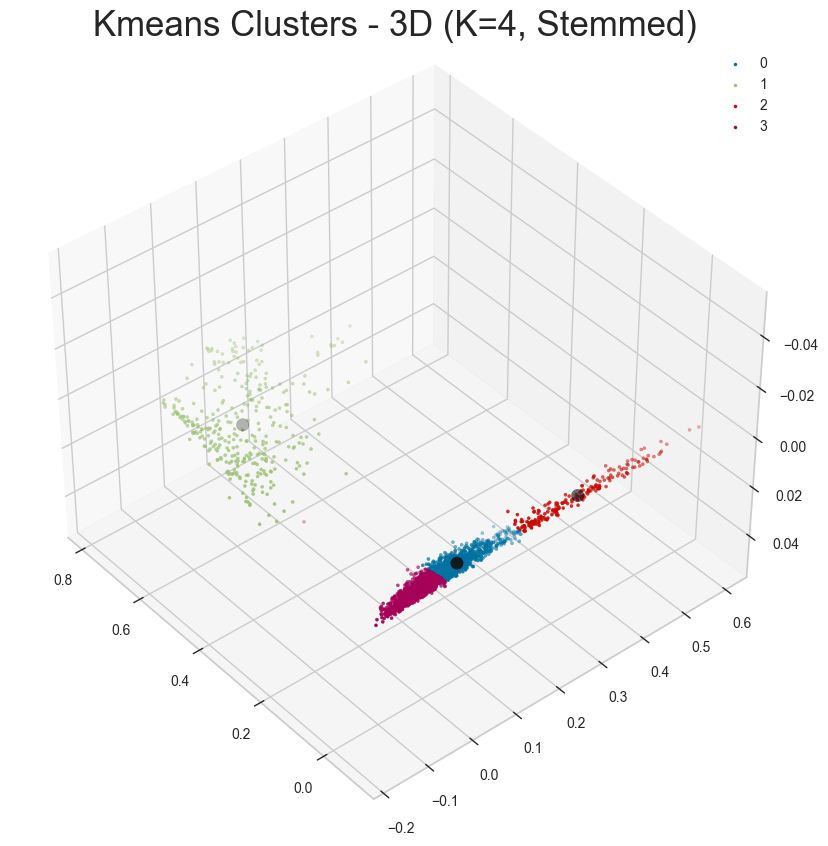

In [177]:
k_ = kmeans(vec_kos_documents_ps,4,pca,"Stemmed")

In [164]:
k_top = k_[1]

In [165]:
vocab_top_11 = list(k_top.values())
vb_top_11= []
for i in vocab_top_11:
    vb_top_11+=i

top_11_dict = {}
for i in vb_top_11:
    if i in top_11_dict:top_11_dict[i]+=1
    else: top_11_dict[i]=1


In [168]:
count= 0
for j in top_11_dict:
    if top_11_dict[j]==3:
        count+=1
print(count)

4601


In [178]:
print(documents_ps)

['action ad administr allianc antiwar approv assault attack attitud aug battl believ broad bush career chairman click coalit committe compar conclud conclus congression congressman consid constitu countri damag damn departur destruct district doug dramat elector engag enlarg fact final gener gooper greater hold hous household inadequ incident independ intellig intern iraq ive john justifi kerri know launch lead letter lower maintain mass member militari mistak nebraska news novemb opportun outgo pennsylvania percent pick pickup preemptiv presid prove reach real relat rep republican reput result reveal richard saddam seat senior slim substanti true vice view vote voter war weaken weapon wmd wrong wrote zone', 'ambiti aug boat book border bush call campaign christma click command cross cspan damn debat drop enlarg forc gener group ill insid john kerri member michael mission moment occas onlin oper place play pool request respond secretari servic special spokesman statement swift time tru